In [16]:
import pandas as pd
import torch
from fastai.tabular.all import *
import matplotlib.pylab as plt
pd.options.mode.chained_assignment = None

In [2]:
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

drop_columns = ['koi_pdisposition', 'kepid', 'kepoi_name', 'kepler_name', 'koi_tce_delivname']

train_koi_score = train_df.drop(columns=drop_columns + ['koi_disposition'])
test_Y_koi_score = torch.tensor(test_df['koi_score'].to_numpy().reshape(-1, 1), dtype=torch.float32)
test_X_koi_score = test_df.drop(columns=drop_columns + ['koi_disposition', 'koi_score'])

### FFNN regressor for KOI Score

In [3]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_koi_score))

In [4]:
to = TabularPandas(train_koi_score,
                  procs = [Categorify, FillMissing, Normalize],
                  cat_names = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'],
                  cont_names = [
                     'koi_period',
                     'koi_period_err1',
                     'koi_period_err2',
                     'koi_time0bk',
                     'koi_time0bk_err1',
                     'koi_time0bk_err2',
                     'koi_impact',
                     'koi_impact_err1',
                     'koi_impact_err2',
                     'koi_duration',
                     'koi_duration_err1',
                     'koi_duration_err2',
                     'koi_depth',
                     'koi_depth_err1',
                     'koi_depth_err2',
                     'koi_prad',
                     'koi_prad_err1',
                     'koi_prad_err2',
                     'koi_teq',
                     'koi_insol',
                     'koi_insol_err1',
                     'koi_insol_err2',
                     'koi_model_snr',
                     'koi_tce_plnt_num',
                     'koi_steff',
                     'koi_steff_err1',
                     'koi_steff_err2',
                     'koi_slogg',
                     'koi_slogg_err1',
                     'koi_slogg_err2',
                     'koi_srad',
                     'koi_srad_err1',
                     'koi_srad_err2',
                     'ra',
                     'dec',
                     'koi_kepmag',
                  ],
                  y_names='koi_score',
                  y_block=RegressionBlock(),
                  splits=splits,
                  inplace=True, 
                  reduce_memory=True)

In [5]:
dls = to.dataloaders(bs=128)
dls.show_batch()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_score
0,0,1,1,1,9.122093,0.000071,-0.000071,138.833053,0.00785,-0.00785,1.236,71.849999,-0.298,4.347,0.226,-0.226,906.799772,47.700001,-47.700001,28.170000,9.15,-3.050000,863.000000,131.349944,129.399978,-40.690117,22.200018,1.0,5899.000010,184.000000,-205.000001,4.499,0.040,-0.229,0.960,0.312,-0.104,293.078339,42.277039,15.676,0.000
1,0,1,1,0,16.003517,0.000067,-0.000067,146.388122,0.00333,-0.00333,1.209,72.330004,-0.458,4.001,0.166,-0.166,668.301546,26.700001,-26.700001,18.010000,2.09,-1.710000,586.000021,27.830068,11.179818,-7.629887,29.900003,1.0,5283.000003,157.000001,-157.000000,4.594,0.065,-0.058,0.695,0.081,-0.066,297.918640,45.347061,14.733,0.000
2,0,0,0,0,10.919265,0.000114,-0.000114,134.267883,0.00733,-0.00733,0.434,0.020000,-0.434,4.572,0.223,-0.223,91.099532,7.099999,-7.099999,1.900000,0.24,-0.440000,1106.999999,355.290139,121.689978,-155.750161,15.000012,1.0,5745.000002,86.000000,-69.000001,3.939,0.189,-0.081,1.972,0.246,-0.458,294.540405,44.190979,13.534,1.000
3,0,1,1,0,1.129764,0.000015,-0.000015,132.526000,0.01180,-0.01180,0.338,0.130000,-0.338,3.096,0.343,-0.343,133.698878,12.800001,-12.800001,0.829999,0.13,-0.060001,1428.999992,987.440335,505.519936,-235.230131,14.299990,1.0,5366.000006,160.000000,-160.000000,4.625,0.032,-0.097,0.715,0.114,-0.052,294.306519,39.765282,15.625,0.000
4,0,0,0,0,30.863947,0.000107,-0.000107,162.880768,0.00279,-0.00279,0.907,0.014000,-0.649,8.864,0.110,-0.110,256.500420,4.700001,-4.700001,3.010000,0.16,-0.130000,743.000004,72.049617,12.479884,-9.150025,62.999999,1.0,5976.999989,79.999998,-79.999998,4.080,0.020,-0.018,1.571,0.086,-0.063,293.229950,45.053310,12.547,0.998
5,0,0,0,0,5.341823,0.000041,-0.000041,136.318604,0.00640,-0.00640,0.070,0.380000,-0.070,3.577,0.163,-0.163,70.500163,4.100001,-4.100001,0.950001,0.14,-0.170000,1124.999999,379.089880,159.100082,-140.910342,19.200016,1.0,5766.999998,115.000000,-103.999998,4.287,0.162,-0.108,1.135,0.165,-0.202,288.660767,43.368080,13.455,0.989
6,0,0,0,0,142.703881,0.002266,-0.002266,212.031098,0.01030,-0.01030,0.062,0.376000,-0.062,5.808,0.333,-0.333,225.500791,23.800001,-23.800001,1.950000,0.71,-0.230000,439.999988,8.880167,9.149874,-2.939809,11.000000,1.0,6700.999981,161.000000,-240.999996,4.326,0.058,-0.217,1.289,0.463,-0.154,289.680725,49.745831,13.964,0.919
7,0,0,0,0,10.209027,0.000188,-0.000188,140.680496,0.01850,-0.01850,0.213,0.232000,-0.213,6.264,0.564,-0.564,36.699318,4.400003,-4.400003,0.920001,0.17,-0.130000,1057.999999,296.419801,148.260045,-100.160030,9.799999,2.0,6187.999982,110.000000,-135.000001,4.196,0.115,-0.126,1.524,0.278,-0.228,289.773254,40.800720,13.310,0.616
8,0,0,1,0,0.973159,0.000004,-0.000004,132.254121,0.00353,-0.00353,0.034,0.452000,-0.034,0.864,0.191,-0.191,138.300521,20.700000,-20.700000,1.220000,0.39,-0.130000,1932.000009,3303.839935,3066.780007,-1042.560014,9.799999,1.0,6108.000012,172.000000,-236.000002,4.466,0.052,-0.208,1.030,0.323,-0.108,294.868133,44.283199,15.238,0.000
9,0,1,1,1,0.905674,0.000009,-0.000009,132.200653,0.00846,-0.00846,0.008,0.450000,-0.008,1.701,0.264,-0.264,73.199562,10.999999,-10.999999,0.770001,0.23,-0.080000,1780.000021,2374.980120,2162.039984,-696.889987,10.200008,1.0,5729.999999,173.000001,-190.000000,4.518,0.048,-0.204,0.903,0.273,-0.091,289.296997,41.285488,15.384,0.000


In [6]:
tc = tabular_config(ps=[0.001, 0.01], embed_p=0.04, y_range=(0, 1))
learn = tabular_learner(dls, layers=[1000, 500], metrics=R2Score(), config=tc, loss_func=MSELossFlat())
learn.summary()

TabularModel (Input shape: 128 x 4)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 3             
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Dropout                                                        
BatchNorm1d                               72         True      
____________________________________________________________________________
                     128 x 1000          
Linear                                    48000      True      
ReLU                                                           
BatchNorm1d                               2000       True      
Dropout                                                        
____________________________________________________________________________
                     1

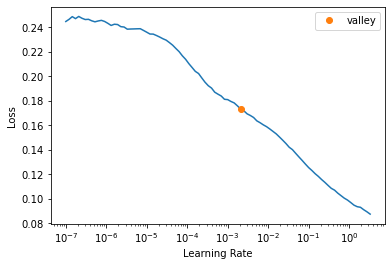

In [7]:
lr = learn.lr_find()

In [8]:
learn.fit_one_cycle(25, lr)

epoch,train_loss,valid_loss,r2_score,time
0,0.117529,0.098614,0.563053,00:00
1,0.099809,0.094929,0.579380,00:00
2,0.086678,0.077625,0.656053,00:00
3,0.064566,0.032366,0.856588,00:00
4,0.043254,0.017628,0.921893,00:00
5,0.030902,0.018284,0.918987,00:00
6,0.024379,0.016749,0.925786,00:00
7,0.020207,0.014033,0.937822,00:00
8,0.017812,0.013771,0.938981,00:00
9,0.016100,0.013013,0.942339,00:00


In [9]:
learn.show_results()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_score,koi_score_pred
0,1.0,2.0,2.0,2.0,-0.410445,-0.182770,0.182770,-0.447413,-0.352524,0.352524,2.521603,-0.063006,0.482266,-0.356883,-0.367198,0.367198,-0.303493,-0.191640,0.191640,0.354710,0.291544,-0.045198,0.687290,-0.035172,-0.033444,0.037327,-0.272316,1.165757,0.225428,-0.016153,-0.607060,0.464932,-0.640662,-1.078538,-0.133274,-0.052003,0.166953,1.195829,0.900004,-0.281194,0.000,0.000183
1,1.0,1.0,1.0,1.0,-0.143948,-0.155228,0.155228,-0.383544,-0.133316,0.133316,0.397491,-0.212875,-0.704183,-0.219942,-0.226706,0.226706,-0.300660,-0.124018,0.124018,-0.061598,-0.049995,0.043413,-0.477679,-0.044864,-0.060016,0.042212,-0.317832,-0.371296,-0.122356,-1.222534,1.167936,-0.532839,0.605622,0.460337,-0.027658,-0.087332,0.019462,-0.097946,-0.701186,0.720009,1.000,0.995517
2,2.0,1.0,1.0,1.0,1.538127,0.129849,-0.129849,2.445360,-0.070767,0.070767,-0.280471,-0.204740,-0.195984,-0.450691,0.154657,-0.154657,-0.301215,0.121881,-0.121881,0.007672,-0.039684,-0.000455,-0.371666,-0.044669,-0.060099,0.041979,-0.338679,-0.371296,-0.968250,-1.139335,0.308172,-3.976129,-0.663051,1.565937,2.105212,0.661883,-1.798761,0.910348,-0.816494,-1.175934,0.157,0.048383
3,1.0,1.0,1.0,1.0,-0.116942,-0.132474,0.132474,-0.240417,0.046297,-0.046297,-0.595015,-0.180857,0.294624,-0.111159,-0.074556,0.074556,-0.308397,-0.190274,0.190274,-0.070988,-0.054403,0.048845,-0.514195,-0.044917,-0.060062,0.042298,-0.334510,2.702810,0.501872,-0.203350,0.363641,-0.119546,0.113078,0.295992,-0.078047,-0.142152,0.111722,1.030714,-0.293875,-0.200403,0.993,0.968039
4,1.0,1.0,1.0,1.0,-0.273590,-0.153948,0.153948,-0.426443,0.163361,-0.163361,0.074174,-0.183673,-0.332807,-0.218195,0.134898,-0.134898,-0.307080,-0.141094,0.141094,-0.070378,-0.052768,0.048845,-0.392868,-0.044713,-0.059191,0.042176,-0.337174,-0.371296,0.547734,0.524639,-1.009207,0.362221,-0.536184,-1.018776,-0.122390,-0.043475,0.148752,-0.950117,0.128220,1.160206,0.989,0.969333
5,2.0,1.0,1.0,1.0,-0.414109,-0.183040,0.183040,-0.451733,-0.414350,0.414350,0.765921,-0.211102,0.519404,-0.527552,-0.476786,0.476786,-0.055030,-0.210766,0.210766,0.047982,0.051123,0.012221,1.107809,-0.023873,0.005494,0.028950,1.483233,1.165757,0.391040,0.982231,-1.009207,0.244835,-0.386928,-1.168181,-0.113118,0.012564,0.136199,-0.016660,-0.542210,-1.210667,0.000,0.106164
6,1.0,1.0,1.0,1.0,0.248886,-0.070768,0.070768,-0.354527,-0.149384,0.149384,-0.274205,-0.206096,-0.205757,0.039074,-0.104196,0.104196,-0.305231,-0.144510,0.144510,-0.069309,-0.051203,0.048728,-0.747424,-0.045122,-0.060260,0.042421,-0.327909,-0.371296,0.710798,0.545438,-0.912137,0.286409,-0.386928,-1.377349,-0.117754,0.023528,0.153773,1.182311,0.903967,0.243570,0.919,0.988240
7,1.0,1.0,1.0,1.0,-0.275308,-0.169684,0.169684,-0.399237,-0.172911,0.172911,0.440098,-0.208286,-0.543905,0.063530,0.682244,-0.682244,-0.304462,-0.161928,0.161928,-0.066535,-0.052555,0.047443,-0.326904,-0.044566,-0.059583,0.042104,-0.311115,1.165757,0.438175,-0.473746,0.377508,0.007621,-0.013789,0.176467,-0.095180,-0.170172,0.124902,1.292978,-0.926134,0.330401,1.000,0.967017
8,1.0,1.0,1.0,1.0,-0.332860,-0.182833,0.182833,-0.462349,-0.409908,0.409908,0.323554,-0.212458,0.558496,-0.293517,-0.468606,0.468606,-0.092088,-0.090207,0.090207,-0.016784,-0.032004,0.020398,-0.100743,-0.043788,-0.058665,0.041398,0.487673,-0.371296,-0.098152,-1.222534,1.154069,-0.457028,0.493680,0.460337,-0.040961,-0.131188,0.027621,1.096523,0.720185,-1.360923,0.973,0.987516


In [17]:
dl = learn.dls.test_dl(test_X_koi_score)
preds, _ = learn.get_preds(dl=dl)
difference = torch.abs(preds - test_Y_koi_score)
correct = (difference < 0.05).sum()
total = test_Y_koi_score.shape[0]
accuracy = correct / total
print(accuracy)

tensor(0.7832)


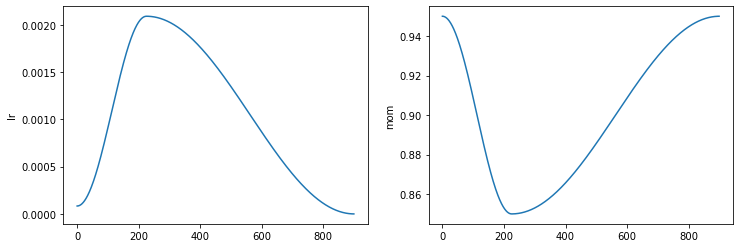

In [18]:
learn.recorder.plot_sched()

Text(0, 0.5, 'count')

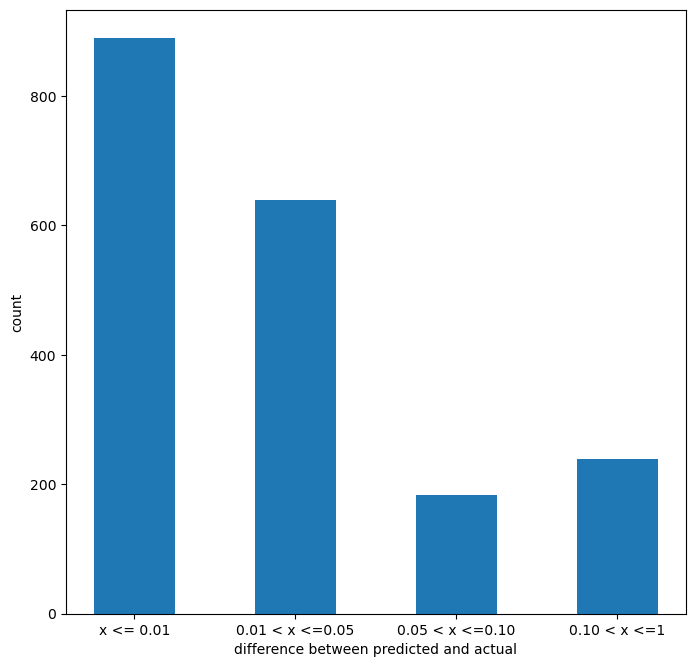

In [75]:
columns = ['0.01', '0.05', '0.10', '1']

count = []
for col in columns:
  count.append((difference <= float(col)).sum())

count = [count[0], *[y - x for x, y in zip(count, count[1:])]]

category = []
for i, col in enumerate(columns):
  if i == 0:
    category.append(f'x <= {col}')
  else:
    category.append(f'{columns[i-1]} < x <={col}')

fig, ax = plt.subplots(1, figsize=(8, 8), dpi=100)
ax.bar(category, count, width=0.5)
ax.set_xlabel('difference between predicted and actual')
ax.set_ylabel('count')

### Conclusion

Considering the random forest regressor is around 95% accurate, there really is not a need for a neural net to solve this problem. 